In [ ]:
!pip install numpy==1.26.4 scikit-learn-extra --force-reinstall --quiet
import numpy as np


In [ ]:
!pip install gower pyclustering pandas numpy matplotlib scikit-learn --quiet

 Introduction

This project focuses on performing unsupervised clustering on the **UCI Adult Income (Census) dataset**, which contains demographic and socio-economic information such as age, education, occupation, marital status, and working hours. The original purpose of this dataset was to predict whether an individual’s annual income exceeds $50,000.    

Since the data consists of both **numerical features** (e.g., age, hours-per-week) and **categorical attributes** (e.g., education, occupation, marital-status), traditional K-Means is not suitable because it relies on Euclidean distance and numerical means.

I did away with the binary classification and treated this purely as unsupervised learning to find clusters as this dataset was a mixed dataset

This trait was needed to implement Gower distance

To address this, I applied **K-Medoids clustering** combined with **Gower distance**, which effectively handles **mixed data types** by computing a composite similarity measure for both numeric and categorical features.  
This approach enables the identification of meaningful population segments and socio-economic patterns within the dataset without requiring labeled income data.

MY GOAL was to uncover hidden socio-economic clusters that may correspond to income-related population groups.

Unlike K-Means, which calculates geometric means for numeric features, K-Medoids selects **actual data points (medoids)** as cluster centers — a crucial property for handling categorical variables where computing a mean is not meaningful.

I cannot find the average of Red, Blue, and Yellow for example.

Gower distance avoids the high-dimensional mess caused by encoding methods while capturing similarity across both numeric and categorical features.


If i use one hot encoding oor anyother type of encoding like label the dimesnions will be enormous for many categorical variable as in data set ,

In [ ]:
#importing necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS
import gower

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

In [ ]:
# defining columns

cols = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

In [ ]:
df = pd.read_csv(url, header=None, names=cols, na_values=" ?", skipinitialspace=True)
#Reads the Adult dataset  na_values=" ?" treats ' ?' as NaN; skipinitialspace=True trims leading spaces.


# This dataset has mixed data binary data which is a perfect fit for GOWER

#1 Continuous → age, capital-gain, capital-loss, hours-per-week
#2 Ordinal → education, education-num
#3Nominal → workclass, marital-status, occupation, relationship, race, native-country
#4 Binary → sex, income
Ignoring  → fnlwgt as its not useful

doing encoding will increase dimensinality of this unsupervised clustering

Continuous → scaled absolute difference

Ordinal → ranked then i take scaled difference

Nominal/Binary → 0 if same, 1 if different

Final Gower Distance = average of all these partial distances

In [ ]:

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
 df.shape

(32561, 15)

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns #choosing only from float or integer types

# Computing skewness
skew_vals = df[num_cols].skew().sort_values(ascending=False)
print(" Skewness for numeric features:\n", skew_vals, "\n")

 Skewness for numeric features:
 capital-gain      11.953848
capital-loss       4.594629
fnlwgt             1.446980
age                0.558743
hours-per-week     0.227643
education-num     -0.311676
dtype: float64 



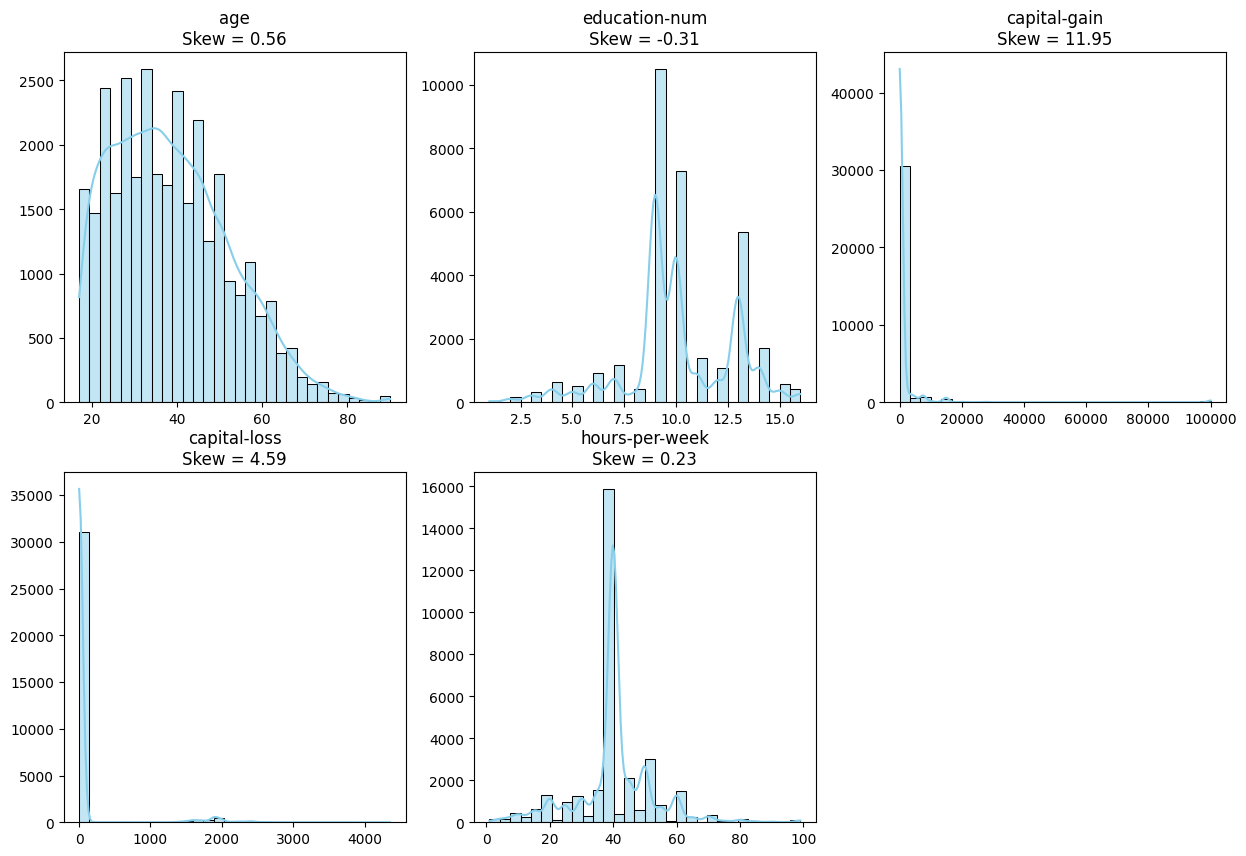

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Calculating skewness
skew_vals = df[num_cols].skew()


plt.figure(figsize=(15, 10))

# Looping  through numerical columns
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns grid (adjust as needed)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"{col}\nSkew = {skew_vals[col]:.2f}", fontsize=12)
    plt.xlabel('')
    plt.ylabel('')



The variables capital-gain (Skew = 11.95) and capital-loss (Skew = 4.59) are highly right-skewed.
Since **K-Means/K-Medoids** clustering algorithms are sensitive to outliers and assume roughly
symmetric (Gaussian-like) distributions, such skewness can distort the distance calculations.Moreover it chooses a real data point

To mitigate this, I will apply a **logarithmic transformation** (log1p) to these features.  
This transformation compresses large values and reduces the impact of extreme outliers,
thereby improving my cluster stability and silhouette scores.I did experimentation too

In [ ]:
import numpy as np

# Applying  log transformation to reduce skewness
df['capital-gain'] = np.log1p(df['capital-gain'])
df['capital-loss'] = np.log1p(df['capital-loss'])

# Checking  new skew values
new_skew = df[['capital-gain', 'capital-loss']].skew()
print(" Skewness after log transform:\n", new_skew)

# i can explore box cox yeo jhonson to find lambda parameter to dee which transformation
#tretament is accurate lambda 1 implies no transformation and close to 0 implies a log and close to 0.5 sqrt

 Skewness after log transform:
 capital-gain    3.096144
capital-loss    4.307537
dtype: float64


In [ ]:
#  Cleaning the  Data and dropping redundant features to trat this as unsupervised like income and prevent any sort of data leakage
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(columns=["fnlwgt","education-num"], inplace=True)
print(" Cleaned dataset:", df.shape)


 Cleaned dataset: (32561, 13)


In [ ]:
#  Selecting  Mixed Features (Continuous + Categorical + Binary)
features = [
    "age","workclass","education","marital-status",
    "occupation","relationship","race","sex",
    "capital-gain","capital-loss","hours-per-week","native-country"
]
X = df[features].copy()

In [ ]:
X.shape

(32561, 12)

In [ ]:
# All category columns = nominal category unless explicitly made ordered.

# Binary columns (2 unique values)will  behave fine automatically.

# Multi-category columns (3+) are treated as nominal (unordered).

In [ ]:
#  Defining  the one and only  Ordinal column (education)
edu_order = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th',
             'HS-grad','Some-college','Assoc-acdm','Assoc-voc',
             'Bachelors','Masters','Doctorate']
X['education'] = pd.Categorical(X['education'], categories=edu_order, ordered=True)


In [ ]:
# I am  converting the coulmns types explictly to avoid confusion
cat_cols = ["workclass","education","marital-status","occupation",
            "relationship","race","sex","native-country"]
num_cols = ["age","capital-gain","capital-loss","hours-per-week"]

X[cat_cols] = X[cat_cols].astype('category')
X[num_cols] = X[num_cols].astype('float')


In [ ]:

sample_size = 2000

In [ ]:
#  SAMPLE DATA for Speed

# gower computes an n×n distance matrix
# so O(n2)
# 30,000 rows (like the Adult dataset)
# that’s 900 million distance computations hence sampling to only 2 k



X = X.sample(n=sample_size, random_state=42).reset_index(drop=True)
print(f"I am Using subset of {sample_size} rows for clustering")

I am Using subset of 2000 rows for clustering


In [ ]:
X_gower = X.copy()
for col in X_gower.select_dtypes(['category']).columns:
    X_gower[col] = X_gower[col].astype(str)

    ## Converting categorical columns to strings  for matching in runtime

In [ ]:

# Converting ordinal (education) to numeric rank codes
X_gower['education'] = X['education'].cat.codes.astype(float)

In [ ]:
#scaling  min max
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
print(" Applied MinMax Scaling to numeric features.")


 Applied MinMax Scaling to numeric features.


Computing gower distance and matrix

In [ ]:
#  Compute Gower distance

gower_dist = gower.gower_matrix(X_gower)
print(" Gower matrix shape:", gower_dist.shape)


 Gower matrix shape: (2000, 2000)


In [ ]:
import random
from pyclustering.cluster.kmedoids import kmedoids

In [ ]:
#  K-Medoids clustering
n_clusters = 4  # choosing 4 clusters
random.seed(42)
initial_medoids = random.sample(range(len(X_gower)), n_clusters)

kmed = kmedoids(gower_dist, initial_medoids, data_type='distance_matrix') #it is invoked with the distance matrix (not raw data)
kmed.process()  # running kmedoids
clusters = kmed.get_clusters()  #getting cluster
medoids = kmed.get_medoids()# getting medoid pts or my centers


labels = np.zeros(len(X_gower))# initializing with 0 array
for i, pts in enumerate(clusters):   # assigning cluster
    for p in pts:
        labels[p] = i
X_gower["Cluster"] = labels.astype(int)
print("\ K-Medoids is  done. Cluster sizes:\n", X_gower["Cluster"].value_counts())

<>:17: SyntaxWarning: invalid escape sequence '\ '
<>:17: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-3516955371.py:17: SyntaxWarning: invalid escape sequence '\ '
  print("\ K-Medoids is  done. Cluster sizes:\n", X_gower["Cluster"].value_counts())


\ K-Medoids is  done. Cluster sizes:
 Cluster
0    844
3    485
1    398
2    273
Name: count, dtype: int64


In [ ]:
#  Evaluating Silhouette
sil = silhouette_score(gower_dist, labels, metric="precomputed") # i am Computing  silhouette using the precomputed distance matrix
print(f" Silhouette Score: {sil:.4f}")

 Silhouette Score: 0.2608


In [ ]:
num_summary = X_gower.groupby("Cluster")[num_cols].mean()   # mean value for cluster for numerical columns
print("\n Numeric Feature Means by Cluster:\n", num_summary)



 Numeric Feature Means by Cluster:
                age  capital-gain  capital-loss  hours-per-week
Cluster                                                       
0        44.457346      1.136608      0.485315       43.483412
1        31.600503      0.390793      0.207946       35.527638
2        44.238095      0.549835      0.306658       38.457875
3        32.878351      0.565083      0.296309       40.016495



  Visualizing My  Clusters 
 


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


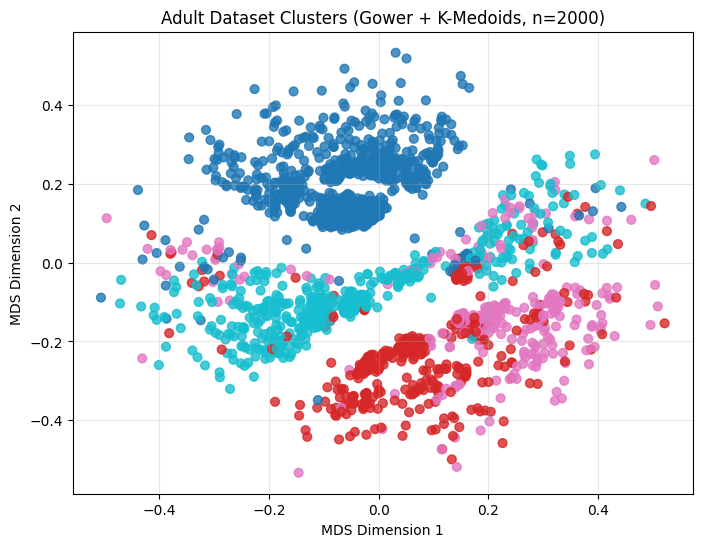

In [ ]:
#  Visualization  using Multi dimensional scaling which is coverting distance matrix into cordinates 2d
print("\n  Visualizing My  Clusters \n ")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(gower_dist)

plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1], c=labels, cmap="tab10", s=40, alpha=0.8)
plt.title(f"Adult Dataset Clusters (Gower + K-Medoids, n={sample_size})")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# My  Medoids
print("My  Representative Medoids:")
print(X.loc[medoids, features ])

My  Representative Medoids:
           age workclass     education      marital-status      occupation  \
1191  0.356164   Private       HS-grad  Married-civ-spouse    Craft-repair   
885   0.164384   Private  Some-college       Never-married    Adm-clerical   
286   0.356164   Private  Some-college            Divorced  Prof-specialty   
1829  0.205479   Private       HS-grad       Never-married    Craft-repair   

       relationship   race     sex  capital-gain  capital-loss  \
1191        Husband  White    Male           0.0           0.0   
885   Not-in-family  White  Female           0.0           0.0   
286       Unmarried  White  Female           0.0           0.0   
1829  Not-in-family  White    Male           0.0           0.0   

      hours-per-week native-country  
1191        0.391753  United-States  
885         0.391753  United-States  
286         0.371134  United-States  
1829        0.391753  United-States  


## Susnata's Conclusion

The clustering analysis was performed on the UCI Adult Income dataset, which contains socio-economic and demographic attributes used to predict whether an individual's annual income exceeds $50,000.  

Since the dataset includes both numerical (e.g., age, hours-per-week) and categorical (e.g., occupation, education, marital status) features, I applied **K-Medoids clustering** with **Gower distance**, which is well-suited for mixed data types.  

The data was grouped into **four distinct clusters**, each representing different socio-economic segments of individuals.  

I did away with the binary classification and treated this purely as unsupervised learning to find clusters as this dataset was a mixed dataset

This trait was needed to implement Gower distance

Visually, the clusters showed moderate separation, indicating some overlap between social groups — which is expected in real-world census data where socio-economic characteristics often blend rather than form rigid categories.  

The **silhouette score of 0.2608** suggests that the clustering achieved a **fair structure** — not highly distinct, but still meaningful enough to identify latent groupings in the population.  
For example, certain clusters were dominated by specific occupations or education levels, reflecting different income and lifestyle segments within the population.  

Overall, the K-Medoids + Gower approach provided interpretable, representative groupings of individuals based on a mix of categorical and numerical socio-economic features, offering useful insights into income-related population patterns.